## Integrate and process the different datasets

Import libraries

In [1]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

Set directories
SRSF2_2 = Training set with known positive control binders
SRSF2_9 = Test set with known true binders
SRSF2_10 = Test set - noisy with no confirmed binders

In [15]:
def set_directories(patient_id, base_dir):
    """
    Generate a dictionary containing paths to relevant directories for a given patient.
    
    Parameters:
    - patient_id (str): The unique identifier for the patient.
    - base_dir (str): The base directory containing all patient data.
    
    Returns:
    - dict: A dictionary with paths to gene expression, dextramer, TCR, and CITE-seq data.
    """
    return {
        "dir_gex": os.path.join(base_dir, f"{patient_id}/CellRangerGex_results"),
        "dir_dex": os.path.join(base_dir, f"{patient_id}_dextramer_count/umi_count"),
        "dir_TCR": os.path.join(base_dir, f"{patient_id}_TCR_VDJ/CellRangerVdj_results"),
        "dir_CITE": os.path.join(base_dir, f"{patient_id}_hash_count/umi_count")
    }

# Define base directory and patient IDs
base_dir = "/Users/ecrosse/Desktop/"

# Set directories for each patient
dirs_SRSF2_2 = set_directories("november_dextramer_data/WJK-2719_SRSF2_2", base_dir)
dirs_SRSF2_9 = set_directories("data_for_edie_third_batch_january/WJK-2859_SRSF2_9", base_dir)
dirs_SRSF2_10 = set_directories("dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10", base_dir)


# Print to verify the directory structure
print (dirs_SRSF2_2)
print(dirs_SRSF2_9)
print(dirs_SRSF2_10)

{'dir_gex': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_hash_count/umi_count'}
{'dir_gex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count'}
{'dir_gex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10/CellRangerGex_results', 'dir_dex': '/User

Data integration and processing function

In [8]:
def load_and_prepare_adata(dirs):
    # Unpack paths
    dir_gex, dir_dex, dir_CITE, dir_TCR = (
        dirs["dir_gex"], dirs["dir_dex"], dirs["dir_CITE"], dirs["dir_TCR"]
    )

    # Load gene expression
    adata = sc.read_10x_h5(os.path.join(dir_gex, "filtered_feature_bc_matrix.h5"))
    adata.var_names_make_unique()

    # Load CITE-seq
    cite_matrix = scipy.io.mmread(f"{dir_CITE}/matrix.mtx.gz").T.tocsr()
    cite_barcodes = pd.read_csv(f"{dir_CITE}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
    cite_features = pd.read_csv(f"{dir_CITE}/features.tsv.gz", header=None, sep='\t')[1].values

    # Load Dextramer
    dex_matrix = scipy.io.mmread(f"{dir_dex}/matrix.mtx.gz").T.tocsr()
    dex_barcodes = pd.read_csv(f"{dir_dex}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
    dex_features = pd.read_csv(f"{dir_dex}/features.tsv.gz", header=None, sep='\t')[1].values

    # Intersect barcodes
    common = list(set(adata.obs_names) & set(cite_barcodes) & set(dex_barcodes))
    adata = adata[adata.obs_names.isin(common)].copy()

    # Align barcode indices
    cite_idx = np.array([np.where(cite_barcodes == bc)[0][0] for bc in adata.obs_names])
    dex_idx = np.array([np.where(dex_barcodes == bc)[0][0] for bc in adata.obs_names])
    adata.obsm["CITE"] = cite_matrix[cite_idx, :]
    adata.obsm["Dextramer"] = dex_matrix[dex_idx, :]
    adata.uns["CITE_features"] = cite_features
    adata.uns["Dextramer_features"] = dex_features

    # QC + normalization
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_counts=500)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    adata.var["highly_variable"] &= ~adata.var_names.str.startswith("TR")
    sc.pp.scale(adata, max_value=10)

    # TCR clonotype integration
    vdj = pd.read_csv(f"{dir_TCR}/filtered_contig_annotations.csv")
    tcr = vdj[
        (vdj["high_confidence"]) &
        (vdj["productive"]) &
        (vdj["chain"].isin(["TRA", "TRB"])) &
        (vdj["umis"] >= 3)
    ][["barcode", "chain", "raw_clonotype_id"]]
    tcr = tcr.groupby("raw_clonotype_id").filter(lambda g: {"TRA", "TRB"}.issubset(set(g["chain"])))
    tcr = tcr.reset_index(drop=True)

    clono = pd.read_csv(f"{dir_TCR}/clonotypes.csv")[["clonotype_id", "cdr3s_aa", "cdr3s_nt"]]
    clono = clono.rename(columns={"clonotype_id": "raw_clonotype_id"})
    tcr = tcr.merge(clono, on="raw_clonotype_id", how="left")

    clonotype_info = tcr[["barcode", "raw_clonotype_id"]].drop_duplicates().set_index("barcode")
    adata.obs = adata.obs.join(clonotype_info, how="left")

    # CITE CLR transform (but no thresholding yet)
    def clr_transform(matrix, eps=1e-9):
        if sp.issparse(matrix): matrix = matrix.toarray()
        gm = np.exp(np.mean(np.log(matrix + eps), axis=1, keepdims=True))
        return np.log((matrix + eps) / (gm + eps))

    adata.obsm["CITE_clr"] = clr_transform(adata.obsm["CITE"])

    return adata


Apply to a sample and find manual CITE-Seq threshold

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


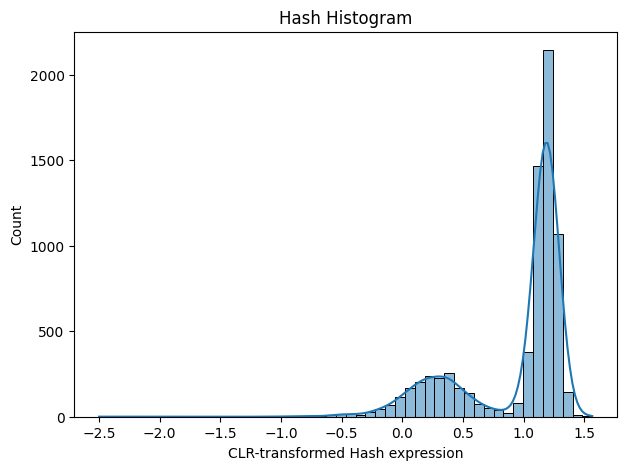

In [19]:
adata = load_and_prepare_adata(dirs_SRSF2_10)

# Then inspect hash distribution
hash_idx = np.where(adata.uns["CITE_features"] == "Hash")[0][0]
hash_values = adata.obsm["CITE_clr"][:, hash_idx]

plt.figure(figsize=(7, 5))
sns.histplot(hash_values, kde=True, bins=50)
plt.xlabel("CLR-transformed Hash expression")
plt.title("Hash Histogram")
plt.show()


Apply threshold to define Dex+ cells

In [20]:
def finalize_adata_after_hash(adata, hash_cutoff=0.8):
    # Locate "Hash" feature index
    hash_idx = np.where(adata.uns["CITE_features"] == "Hash")[0][0]
    
    # Extract CLR-transformed Hash counts
    hash_vals = adata.obsm["CITE_clr"][:, hash_idx]
    adata.obs["HashCounts"] = hash_vals

    # Assign manual hash demux label
    adata.obs["manual_hash_dmux"] = np.where(hash_vals > hash_cutoff, "CITE_hash", "Negative")

    # Remove "unmapped" dextramer feature
    unmapped_idx = np.where(adata.uns["Dextramer_features"] == "unmapped")[0]
    if unmapped_idx.size > 0:
        adata.uns["Dextramer_features"] = np.delete(adata.uns["Dextramer_features"], unmapped_idx[0])
        adata.obsm["Dextramer"] = sp.csr_matrix(
            np.delete(adata.obsm["Dextramer"].toarray(), unmapped_idx[0], axis=1)
        )

    # Add total dextramer counts
    adata.obs["Dextramer_total_counts"] = adata.obsm["Dextramer"].sum(axis=1)

    return adata


Save adata

In [21]:
adata.write("adata_SRSF2_10_processed.h5ad")